In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple, Callable
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from itertools import product
from abc import ABC, abstractmethod

In [2]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(events, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [3]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [4]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.data_preprocessor import DataPreprocessor
from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from metrics.metric import MetricKPI, MetricDinamic

from utils.time_units import TimeUnits

## ТЕстирование метрики KPI

In [5]:
data = generate_user_events_data(num_rows=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
1357,user1,event2,2024-11-29 12:55:16.070160,city5,Android,status2,1357,raw,2
4234,user1,event6,2024-12-01 12:55:16.070160,city5,Android,status2,4234,raw,2
2760,user1,event2,2024-12-21 12:55:16.070160,city6,iOS,status1,2760,raw,2
4934,user1,event9,2025-01-02 12:55:16.070160,city3,iOS,status1,4934,raw,2
1049,user1,event10,2025-01-30 12:55:16.070160,city1,iOS,status2,1049,raw,2


In [6]:
data = ef.to_dataframe()
data['date'] = data['event_datetime'].dt.date

In [7]:
data.head()

,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index,date
1357,user1,event2,2024-11-29 12:55:16.070160,city5,Android,status2,1357,raw,2,2024-11-29
4234,user1,event6,2024-12-01 12:55:16.070160,city5,Android,status2,4234,raw,2,2024-12-01
2760,user1,event2,2024-12-21 12:55:16.070160,city6,iOS,status1,2760,raw,2,2024-12-21
4934,user1,event9,2025-01-02 12:55:16.070160,city3,iOS,status1,4934,raw,2,2025-01-02
1049,user1,event10,2025-01-30 12:55:16.070160,city1,iOS,status2,1049,raw,2,2025-01-30


In [8]:

# period_name = 'date'
hue_cols = ['operation_system', 'status', 'city']
# name = 'city1_users_count'
# formula = lambda x: x[x['city'] == 'city1']['user_id'].nunique()
# formula_kwargs = dict()


# data.groupby([period_name] + hue_cols).apply(lambda data: formula(data, **formula_kwargs), include_groups=False)\
#                 .reset_index().rename(columns={0: name})

def _get_data_pivot_template(self, data: pd.DataFrame, hue_cols: List[str]) -> pd.DataFrame:
    data = data.copy()
    unique_values = [data[col].unique() for col in hue_cols]
        
    # Создаем мультииндекс, представляющий все комбинации
    index = pd.MultiIndex.from_product(unique_values, names=hue_cols)
    
    # Создаем DataFrame с этим мультииндексом
    pivot_template = pd.DataFrame(index=index).reset_index()
    return pivot_template

_get_data_pivot_template(None, data, hue_cols ).shape

(40, 3)

In [8]:
city1_users_count_formula = lambda x: x[x['city'] == 'city1']['user_id'].nunique()
def city_users_count_formula(data, cols_schema,  city='city1'): 
    user_col = cols_schema.user_id
    return data[data['city'] == city][user_col].nunique()

mkpi = MetricKPI(city1_users_count_formula, name='city1_users_count', description='desc')

In [9]:
formula_kwargs = {
    'cols_schema': ef.cols_schema,
    # 'city': 'city7'
}

mkpi.compute_splitted_values(
    ef, 
    hue_cols=['operation_system'], 
    # formula_kwargs=formula_kwargs
)

,operation_system,city1_users_count
0,iOS,226
1,Android,220


In [10]:
mkpi.compute_splitted_values(
    ef.to_dataframe(), 
    hue_cols=['operation_system', 'status'], 
    # formula_kwargs=formula_kwargs
)

,operation_system,status,city1_users_count
0,Android,status2,123
1,Android,status1,111
2,iOS,status2,138
3,iOS,status1,110


In [11]:
mkpi.compute_splitted_values(
    ef.to_dataframe(),  
    # formula_kwargs=formula_kwargs
    )

395

In [12]:
x = ef.to_dataframe()
x[(x['city'] == 'city1') 
#   & (x['operation_system'] == 'Android')
#     & (x['status'] == 'status1')
    ]['user_id'].nunique()

395

## Тестирование метрики динамики


In [13]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')

In [14]:
ef.cols_schema

EventFrameColsSchema(event_id=event_id, event_type=event_type, event_index=event_type_index, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])

In [17]:

(md.compute(ef, period='D', hue_cols=['operation_system', 'status'])['city1_users_count'] == 0).sum()
md.compute(ef, period='M', hue_cols=['operation_system', 'status'])


,Month,operation_system,status,city1_users_count
3,2024-10-01,Android,status1,17
2,2024-10-01,Android,status2,26
1,2024-10-01,iOS,status1,15
0,2024-10-01,iOS,status2,22
7,2024-11-01,Android,status1,17
6,2024-11-01,Android,status2,17
5,2024-11-01,iOS,status1,17
4,2024-11-01,iOS,status2,22
11,2024-12-01,Android,status1,18
10,2024-12-01,Android,status2,17


In [18]:
md = MetricDinamic(city_users_count_formula, name='city_users_count', description='desc')

In [19]:
formula_kwargs = {
    'cols_schema': ef.cols_schema,
    'city': 'city1'
}
data = md.compute(ef, 'D', formula_kwargs=formula_kwargs, hue_cols=['operation_system', 'status'])

## Визуализация метрики динамики

In [23]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from typing import Optional, List, Union, Literal

class DinamicMetricPlotter:
    def __init__(self, engine: str = 'plotly'):
        if engine not in ['seaborn', 'plotly']:
            raise ValueError("Engine must be either 'seaborn' or 'plotly'")
        self.engine = engine

    @staticmethod
    def plot(data: pd.DataFrame, dt_col: str, value_col: str,
             aggfunc: Union[str, Callable] = 'sum',
             hue_cols: Optional[List[str]] = None,
             smooth: int = 0,
             mode: Literal['bar', 'line', 'auto'] = 'auto',
             add_text: Union[str, bool] = 'auto',
             engine: str = 'plotly'):
        if engine not in ['seaborn', 'plotly']:
            raise ValueError("Engine must be either 'seaborn' or 'plotly'")
        
        if engine == 'seaborn':
            DinamicMetricPlotter._plot_seaborn(data, dt_col, value_col, aggfunc, hue_cols, smooth, mode, add_text)
        elif engine == 'plotly':
            DinamicMetricPlotter._plot_plotly(data, dt_col, value_col, hue_cols, mode, add_text)

    @staticmethod
    def smooth_time_series(data: pd.Series, window_size: int) -> pd.Series:
        """
        Применяет скользящее среднее для сглаживания временного ряда.
        
        :param data: pd.Series — временной ряд для сглаживания.
        :param window_size: int — размер окна для скользящего среднего.
        :return: pd.Series — сглаженный временной ряд.
        """
        if window_size < 1:
            return data
        # Применяем скользящее среднее
        return data.rolling(window=window_size, center=False).mean()

    @staticmethod
    def _plot_seaborn(data: pd.DataFrame, dt_col: str, value_col: str, aggfunc: Union[str, Callable],
                      hue_cols: Optional[List[str]] = None, smooth:int = 0, mode: Literal['bar', 'line', 'auto'] = 'auto', 
                      add_text: Union[str, bool] = 'auto'):
        
        if isinstance(hue_cols, str):
            hue_cols = [hue_cols]
        elif hue_cols is None or len(hue_cols) == 0:
            hue_cols = []

        data = data.groupby([dt_col] + hue_cols).agg(**{
            value_col: (value_col, aggfunc)
        }).reset_index()
        # return data
        with sns.axes_style("darkgrid"):
            fig, axes = plt.subplots(figsize=(9, 4))

            if len(hue_cols) == 0:
                data.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(data[value_col], smooth)
                # Отрисовка без hue
                if mode == 'bar':
                    sns.barplot(data=data, x=dt_col, y=value_col, ax=axes)
                elif mode == 'line':
                    sns.lineplot(data=data, x=dt_col, y=value_col, ax=axes)
                else:
                    # Авто-определение режима
                    if data[dt_col].nunique() < 20:
                        sns.barplot(data=data, x=dt_col, y=value_col, ax=axes)
                    else:
                        sns.lineplot(data=data, x=dt_col, y=value_col, ax=axes)
            else:
                # У нас есть hue_cols
                if len(hue_cols) == 1:
                    unique_hues = data[hue_cols[0]].unique()
                    for hue in unique_hues:
                        subset = data[data[hue_cols[0]] == hue]
                        subset.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(subset[value_col], smooth)
                        if mode == 'bar':
                            sns.barplot(data=subset, x=dt_col, y=value_col, label=hue)
                        elif mode == 'line':
                            sns.lineplot(data=subset, x=dt_col, y=value_col, label=hue)
                        else:
                            if subset[dt_col].nunique() < 20:
                                sns.barplot(data=subset, x=dt_col, y=value_col, label=hue)
                            else:
                                sns.lineplot(data=subset, x=dt_col, y=value_col, label=hue)
                else:
                    # Более одного hue
                    unique_combinations = data[hue_cols].drop_duplicates()
                    for _, combo in unique_combinations.iterrows():
                        combo_label  = ' & '.join(combo.apply(lambda x: f"{combo.index[combo == x][0]}={x}"))
                        subset = data[(data[hue_cols] == combo).all(axis=1)]
                        subset.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(subset[value_col], smooth)
                        if mode == 'bar':
                            sns.barplot(data=subset, x=dt_col, y=value_col, label=combo_label)
                        elif mode == 'line':
                            sns.lineplot(data=subset, x=dt_col, y=value_col, label=combo_label)
                        else:
                            if subset[dt_col].nunique() < 20:
                                sns.barplot(data=subset, x=dt_col, y=value_col, label=combo_label)
                            else:
                                sns.lineplot(data=subset, x=dt_col, y=value_col, label=combo_label)

    @staticmethod
    def _plot_plotly(data: pd.DataFrame, dt_col: str, value_col: str,
                     hue_cols: Optional[List[str]], aggfunc: Union[str, Callable], mode: Literal['bar', 'line', 'auto'],
                     add_text: Union[str, bool]):
        
        if isinstance(hue_cols, str):
            hue_cols = [hue_cols]
        elif hue_cols is None or len(hue_cols) == 0:
            hue_cols = []

        data = data.groupby([dt_col] + hue_cols).agg(**{
            value_col: (value_col, aggfunc)
        }).reset_index()

        if mode == 'auto':
            if data[dt_col].nunique() < 20:
                mode = 'bar'
            else:
                mode = 'line'
        
        if len(hue_cols) == 0:
            # Отрисовка без hue
            if mode == 'bar':
                fig = px.bar(data, x=dt_col, y=value_col, text_auto=True)
            elif mode == 'line':
                fig = px.line(data, x=dt_col, y=value_col, text_auto=True)

        elif len(hue_cols) == 1:
            if mode == 'line':
                fig = px.line(data, x=dt_col, y=value_col, color=hue_cols[0], text_auto=True)
            else:
                fig = px.bar(data, x=dt_col, y=value_col, color=hue_cols[0], text_auto=True)
        else:
            fig = None
            unique_combinations = data[hue_cols].drop_duplicates()
            for _, combo in unique_combinations.iterrows():
                combo_label  = ' & '.join(combo.apply(lambda x: f"{combo.index[combo == x][0]}={x}"))
                subset = data[(data[hue_cols] == combo).all(axis=1)]
                subset.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(subset[value_col], smooth)
                if mode == 'bar':
                    sns.barplot(data=subset, x=dt_col, y=value_col, label=combo_label)
                elif mode == 'line':
                    sns.lineplot(data=subset, x=dt_col, y=value_col, label=combo_label)

            fig = px.line(data, x=dt_col, y=value_col, color=hue_cols) if mode == 'line' else px.bar(data, x=dt_col, y=value_col, color=hue_cols)
        
        # Отображение текста, если нужно
        if add_text:
            fig.update_traces(text=data[value_col] if isinstance(add_text, str) and add_text == 'text' else None, textposition="auto")

        fig.show()

# Пример использования
# plotter = DinamicMetricPlotter('seaborn')
# plotter.plot(data, 'date_column', 'value_column', hue_cols=['hue_column'])

# или plotter = DinamicMetricPlotter('plotly')
# plotter.plot(data, 'date_column', 'value_column', hue_cols=['hue_column'])

In [24]:
dt_col = 'date'
value_col = 'city_users_count'
aggfunc = 'sum'

def _plot_plotly(data: pd.DataFrame, dt_col: str, value_col: str,
                     hue_cols: Optional[List[str]], mode: Literal['bar', 'line', 'auto'],
                     add_text: Union[str, bool]):
        
    if hue_cols is None or len(hue_cols) == 0:
        # Отрисовка без hue
        if mode == 'bar':
            fig = px.bar(data, x=dt_col, y=value_col)
        elif mode == 'line':
            fig = px.line(data, x=dt_col, y=value_col)
        else:
            if data[dt_col].nunique() < 20:
                fig = px.bar(data, x=dt_col, y=value_col)
            else:
                fig = px.line(data, x=dt_col, y=value_col)
    else:
        # У нас есть hue_cols
        if len(hue_cols) == 1:
            
            fig = px.line(data, x=dt_col, y=value_col, color=hue_cols[0]) if mode == 'line' else px.bar(data, x=dt_col, y=value_col, color=hue_cols[0])
        else:
            fig = px.line(data, x=dt_col, y=value_col, color=hue_cols) if mode == 'line' else px.bar(data, x=dt_col, y=value_col, color=hue_cols)
    
    # Отображение текста, если нужно
    if add_text:
        fig.update_traces(text=data[value_col] if isinstance(add_text, str) and add_text == 'text' else None, textposition="auto")

    fig.show()

In [27]:
_plot_plotly(data, dt_col, value_col, hue_cols=None, mode='bar', add_text=None)

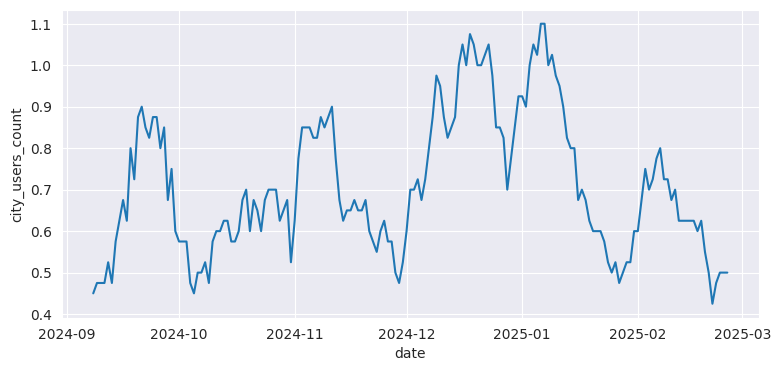

In [23]:
dmp = DinamicMetricPlotter()
data = md.compute(ef, 'D', formula_kwargs=formula_kwargs, hue_cols=['operation_system', 'status'])
dmp.plot(data, dt_col='date', value_col='city_users_count', hue_cols=[], engine='seaborn', aggfunc='mean', mode='auto', smooth=10)
